## Evaluating the budget of oxygen using watermass transformation
Conservation of the mass of tracer with concentration $\phi$, within a volume defined by contours of $\lambda$ is given by  
$$ \partial_t\Phi(\lambda',t) = \mathcal{E}_\phi(\lambda',t) + \sum_n \mathcal{P}^{(n)}_\phi(\lambda',t) \, dV \, $$
where
$$ \Phi(\lambda',t) = \iiint_{\lambda \geq \lambda'} \rho(x,y,z,t)\phi(x,y,z,t) \, dV \, , $$
is the total mass of tracer within the volume,
$$ \mathcal{E}_\phi(\lambda',t) = \frac{\partial}{\partial \lambda}\iiint_{{\lambda}(x,y,z,t)\leq\lambda'} \phi(x,y,z,t) \rho(x,y,z,t) \dot{\lambda}(x,y,z,t) \, dV \, , $$
is the transport of tracer due to dia-boundary masss transport (watermasss transformation), and 
$$\mathcal{P}^{(n)}_\phi(\lambda',t) = \iiint_{\lambda \geq \lambda'} \dot{\phi}^{(n)}(x,y,z,t) \, dV \, .$$
is the volume-integrated tendency of $\phi$ due to process $n$.


In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt

### Load data and calculate budget terms

In [37]:
# Load the data
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '14'
filename = '08990101.ocean_daily.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename).squeeze()
filename_snap = '08990101.ocean_daily_snap.nc'
ds_snap = xr.open_dataset(rootdir+runname+'/history/'+filename_snap).squeeze()

filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)
rho0=ds['rhozero'].values
cp=ds['cpocean'].values

# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap',
            'o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']

# Close oxygen budget
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in o2_terms[:-1]:
    ds[term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds,o2_terms[1:],o2_terms[0],plot=False)
ds['o2_vdiffuse_impl']=error

# Calculate material derivative and diffusive terms
# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# SALT
# signsLHS = [-1,1,1]
# signsRHS = [1,1,1]
# termsLHS = salt_terms[:3]
# termsRHS = salt_terms[3:]
# Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [45]:
def calc_refine(da,refineby,variable_type,vertc='zl'):
    nk = len(da[vertc])
    # Set vertical coordinate to layer index
    da=da.assign_coords({vertc:np.linspace(1,nk,nk)})
    # Assign a k-value for the interfaces
    k_i = np.linspace(0.5,nk+0.5,nk+1)
    # Develop the super grid, based on the interfaces
    k_i_target = np.linspace(0.5,nk+0.5,nk*refineby+1)
    # Get the value of the layers on the super grid
    k_l_target = 0.5*(k_i_target[1:]+k_i_target[:-1])
    
    # Refine the grid
    if variable_type == 'intensive':
        da_refined = da.interp({vertc:k_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
    if variable_type == 'extensive':
        da_refined = xr.zeros_like(da.interp({vertc:k_l_target}))
        for k in range(nk):
            index = np.arange(k*refineby,(k+1)*refineby)
            vertc_ones = xr.DataArray(np.ones(shape=(refineby)),dims=[vertc],coords={vertc:k_l_target[index]})
            chunk = (da.isel({vertc:k})/refineby)*vertc_ones
            # Input array must have same dimensional order as indexed array
            ### THERE MUST BE A MORE EFFICIENT WAY TO DO THIS ###
            if len(da.dims)==1:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk
            elif len(da.dims)==2:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1])
            elif len(da.dims)==3:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2])
            elif len(da.dims)==4:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2],list(da.dims)[3])
    return da_refined

### Calculate budget of volume-integrated oxygen

In [47]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
dl = dheat/cp # Sum of diffusive tendencies for volume-defining tracer
c = xr.ones_like(ds['o2']) # Time-mean of budget tracer

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap['temp'] # Snapshots of volume-defining tracer
c_snap = xr.ones_like(ds_snap['o2']) # Snapshots of budget tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

# Grid dimensions
area = grid.areacello # Grid dimensions

# Time-mean tendencies of budget tracer due to different processes
h_c = ds['o2_dfxy_cont_tendency'] # Parameterized horizontal diffusion
f_c = ds['o2_vdiffuse_impl']      # Vertical diffusion and surface fluxes
b_c = ds['jo2']                   # Biological processes

# Refine grid?
refine=False
refineby=0

In [48]:
# Refine vertical grid
if refine:
    l = calc_refine(l, refineby=refineby, variable_type='intensive')
    dl = calc_refine(dl, refineby=refineby, variable_type='extensive')
    c = calc_refine(c, refineby=refineby, variable_type='intensive')
    l_snap = calc_refine(l_snap, refineby=refineby, variable_type='intensive')
    c_snap = calc_refine(c_snap, refineby=refineby, variable_type='intensive')
    h_snap = calc_refine(h_snap, refineby=refineby, variable_type='extensive')

    h_c = calc_refine(h_c, refineby=refineby, variable_type='extensive')
    f_c = calc_refine(f_c, refineby=refineby, variable_type='extensive')
    b_c = calc_refine(b_c, refineby=refineby, variable_type='extensive')

In [51]:
# Binning variables
delta_l = 0.5
l_i_vals = np.arange(-4,36,delta_l)

# Calculation of budget tracer content tendency, derived from snapshots
C = wmt.calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area) # Binning at snapshots
dCdt = C.diff('time')/(C.time.diff('time').astype('float')*1E-9)
dCdt = dCdt.isel(time=0)
# dCdt = C.differentiate('time').isel(time=0) # Finite difference in time
# dCdt = dCdt.rename({l_snap.name+'_bin':l_name}) # Rename dimension for consistency
# Calculation of E : budget tracer tendency due to dia-boundary mass transport 
E_c = wmt.calc_E(c,l,dl,l_i_vals,area,plot=False).isel(time=1)
# Calculation of P^n : volume integrated budget tracer tendencies
# H_c = wmt.calc_P(h_c,l,l_i_vals,area).isel(time=1)
# F_c = wmt.calc_P(f_c,l,l_i_vals,area).isel(time=1)
# B_c = wmt.calc_P(b_c,l,l_i_vals,area).isel(time=1)

<xarray.DataArray ()>
array(1.17176104e+11)
Coordinates:
    time     object 0899-01-01 12:00:00


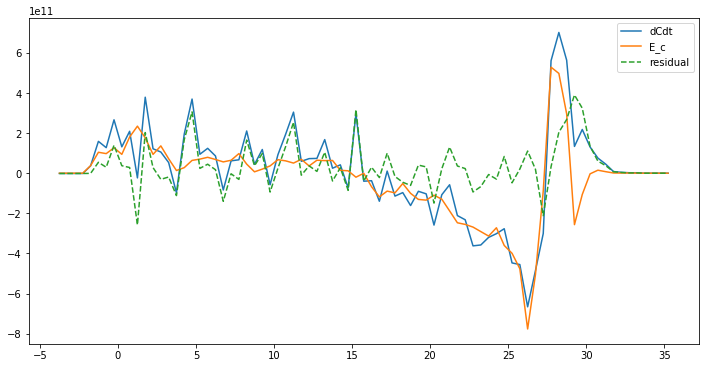

In [52]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt[l_name],dCdt,label='dCdt')
ax1.plot(E_c[l_name],E_c,label='E_c')
# ax1.plot(H_c[l_name],H_c,label='H_c')
# ax1.plot(F_c[l_name],F_c,label='F_c')
# ax1.plot(B_c[l_name],B_c,label='B_c')
residual = dCdt-E_c#-H_c-F_c-B_c
ax1.plot(residual[l_name],residual,linestyle='--',label='residual')
ax1.legend()
print(np.sqrt(np.mean(residual**2)))

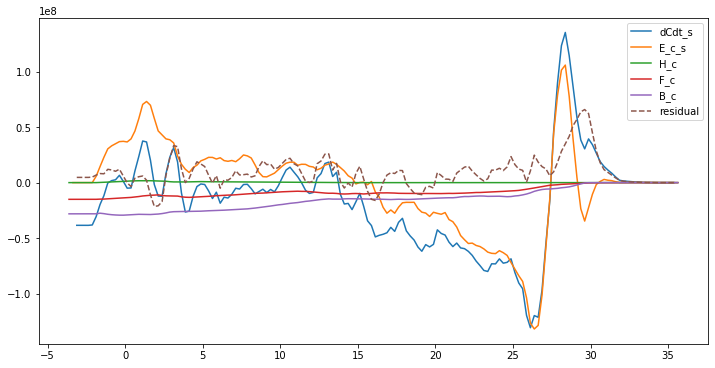

In [22]:
smoothing = 4
dCdt_s = dCdt.rolling({l_name:smoothing},center=True).mean()
smoothing = 4
E_c_s = E_c.rolling({l_name:smoothing},center=True).mean()
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt[l_name],dCdt_s,label='dCdt_s')
ax1.plot(E_c[l_name],E_c_s,label='E_c_s')
ax1.plot(H_c[l_name],H_c,label='H_c')
ax1.plot(F_c[l_name],F_c,label='F_c')
ax1.plot(B_c[l_name],B_c,label='B_c')
residual = dCdt_s-E_c_s-H_c-F_c-B_c
ax1.plot(residual[l_name],residual,linestyle='--',label='residual')
ax1.legend()

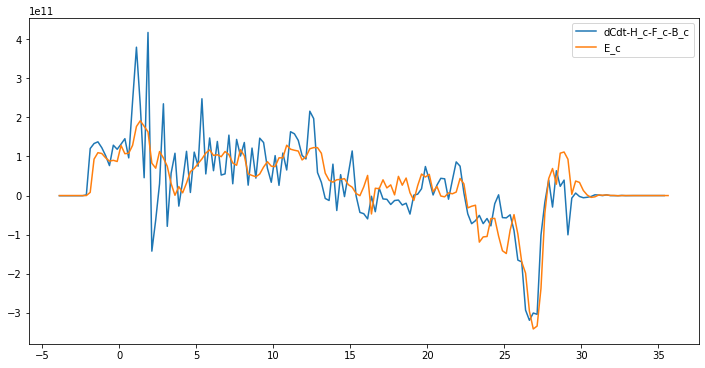

In [13]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
residual = dCdt-H_c-F_c-B_c
ax1.plot(residual[l_name],residual,label='dCdt-H_c-F_c-B_c')
ax1.plot(E_c[l_name],E_c,label='E_c')
ax1.legend()

### Calculate budget of volume-integrated heat

In [35]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
dl = dheat/cp # Sum of diffusive tendencies for volume-defining tracer
c = ds['temp']*cp # Time-mean of budget tracer

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds['temp_snap'] # Snapshots of volume-defining tracer
c_snap = ds['temp_snap'] # Snapshots of budget tracer
h_snap = ds['thkcello_snap']*cp # Snapshots of layer thickness (for tracer content calculation)

# Grid dimensions
area = grid.areacello # Grid dimensions

# Time-mean tendencies of budget tracer due to different processes
f_c = ds['boundary_forcing_heat_tendency'] # Surface boundary heating
g_c = ds['internal_heat_heat_tendency']    # Geothermal heating
v_c = ds['opottempdiff']                   # Vertical diffusion and surface fluxes
h_c = ds['opottemppmdiff']                 # Parameterized horizontal diffusion
z_c = ds['frazil_heat_tendency']           # Formation of frazil ice

# Binning variables
delta_l = 0.25
l_i_vals = np.arange(-4,36,delta_l)

# Calculation of budget tracer content tendency, derived from snapshots
C = wmt.calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area) # Binning at snapshots
dCdt = C.differentiate('time').isel(time=1) # Finite difference in time
dCdt = dCdt.rename({l_snap.name+'_bin':l_name}) # Rename dimension for consistency
# Calculation of E : budget tracer tendency due to dia-boundary mass transport 
E_c = wmt.calc_E(c,l,dl,l_i_vals,area,plot=False).isel(time=1)
# Calculation of P^n : volume integrated budget tracer tendencies
F_c = wmt.calc_P(f_c,l,l_i_vals,area).isel(time=1)
G_c = wmt.calc_P(g_c,l,l_i_vals,area).isel(time=1)
V_c = wmt.calc_P(v_c,l,l_i_vals,area).isel(time=1)
H_c = wmt.calc_P(h_c,l,l_i_vals,area).isel(time=1)
Z_c = wmt.calc_P(z_c,l,l_i_vals,area).isel(time=1)

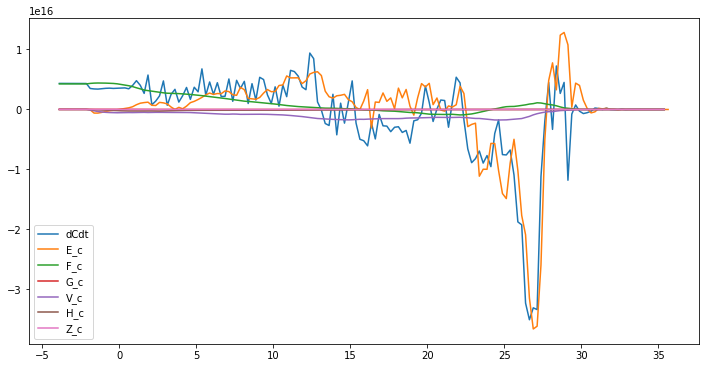

In [36]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt[l_name],dCdt,label='dCdt')
ax1.plot(E_c[l_name],E_c,label='E_c')
ax1.plot(F_c[l_name],F_c,label='F_c')
ax1.plot(G_c[l_name],G_c,label='G_c')
ax1.plot(V_c[l_name],V_c,label='V_c')
ax1.plot(H_c[l_name],H_c,label='H_c')
ax1.plot(Z_c[l_name],Z_c,label='Z_c')
# residual = dCdt-E_c-H_c-F_c-B_c
# ax1.plot(residual[l_name],residual,linestyle='--',label='residual')
ax1.legend()

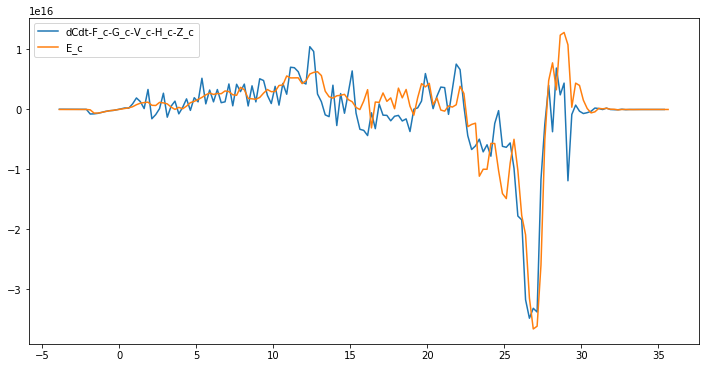

In [40]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
residual = dCdt-F_c-G_c-V_c-H_c-Z_c
ax1.plot(residual[l_name],residual,label='dCdt-F_c-G_c-V_c-H_c-Z_c')
ax1.plot(E_c[l_name],E_c,label='E_c')
ax1.legend()

In [33]:
cp

array(3992.)